- Make a matching reference pair (closest day and night scenes)
- PIF-LRM for day and night seperately
- Should still be able to compare because of the matching reference pair
- Absolute values become unreliable, but the spatial pattern is still reliable and the difference between day and night
  - Thus we can run spatial statistics like hotspotting, Getis Ord, etc to find clustered areas

- Do we:
  - LST -> recenter -> UHI

# UHI

In [2]:
import rioxarray as rxr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from rasterio.plot import show

import xarray as xr
import rasterio
from scipy.stats import mannwhitneyu

In [3]:
day_path = 'out/DAY/LSTK_median_sm.tif'
night_path = 'out/NIGHT/LSTK_median_sm.tif'

day = rxr.open_rasterio(day_path).squeeze()
night = rxr.open_rasterio(night_path).squeeze()

# Reassert grid and projections

night = night.rio.reproject_match(day)

In [4]:
ucl = gpd.read_file("data/ucl.gpkg")
urban = ucl[ucl["sos_code_2021"].isin(["10","11"])]
urban.to_file("urban.gpkg", driver="GPKG")

In [5]:
urban_mask = day.rio.clip(urban.geometry, drop = False, invert = False).notnull()
rural_mask = day.rio.clip(urban.geometry, drop = False, invert = True).notnull()

In [6]:
day_urban = day.where(urban_mask)
night_urban = night.where(urban_mask)

day_rural = day.where(urban_mask)
night_rural = night.where(urban_mask)

In [7]:
day_rur_mean = float(day.where(rural_mask).mean(skipna=True))
night_rur_mean = float(night.where(rural_mask).mean(skipna=True))

# Pixelwise UHI

UHI_day = day - day_rur_mean
UHI_night = night - night_rur_mean

UHI_day.rio.to_raster("out/DAY/UHI_day.tif", dtype="float32")
UHI_night.rio.to_raster("out/NIGHT/UHI_night.tif", dtype="float32")

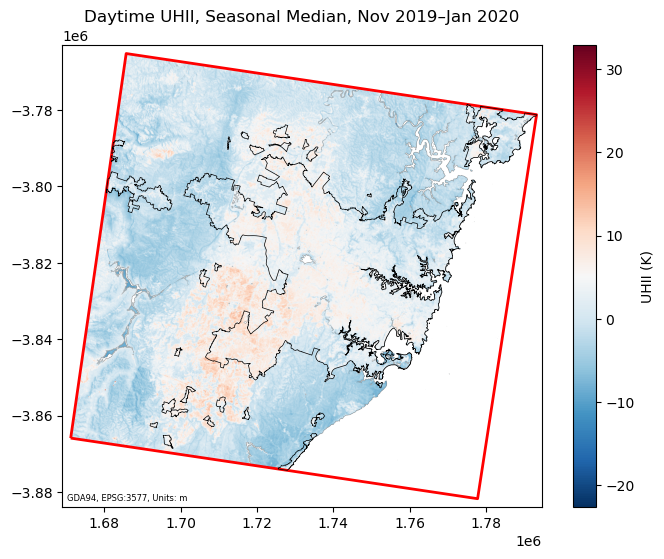

Min: -22.61505126953125 K
Max: 32.870361328125 K
Mean: 0.8937912093420615 K
Std: 3.983754935464915 K


In [18]:
out_path = Path('out/DAY/UHI_day.tif')
bbox_path = "bbox_sm.gpkg"

with rasterio.open(out_path) as src:
    arr = src.read(1).astype(float)

    # Turn nodata into NaN (if defined)
    if src.nodata is not None:
        arr[arr == src.nodata] = np.nan

    fig, ax = plt.subplots(figsize=(8,6))
    im = show(
        src,
        ax=ax,
        cmap='RdBu_r',
    )
    cbar = fig.colorbar(im.get_images()[0], ax=ax)
    cbar.set_label("UHII (K)")
    plt.title("Daytime UHII, Seasonal Median, Nov 2019–Jan 2020")

    bbox_gdf = gpd.read_file(bbox_path).to_crs(src.crs)
    bbox_gdf.boundary.plot(ax=ax, edgecolor="red", linewidth=2)

    urban_gdf = gpd.read_file("urban.gpkg")
    if urban_gdf.crs != src.crs:
        urban_gdf = urban_gdf.to_crs(src.crs)

    urban_clipped = gpd.clip(urban_gdf, bbox_gdf)
    urban_clipped.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5)

    ax.annotate(
        "GDA94, EPSG:3577, Units: m",
        xy=(0.01, 0.01),
        xycoords='axes fraction',
        fontsize=6,
        ha='left',
        va='bottom',
        bbox=dict(facecolor='white', alpha=0.0, edgecolor='none'),
        zorder=1000
    )

    plt.show()

print("Min:", np.nanmin(arr), "K")
print("Max:", np.nanmax(arr), "K")
print("Mean:", np.nanmean(arr), "K")
print("Std:", np.nanstd(arr), "K")

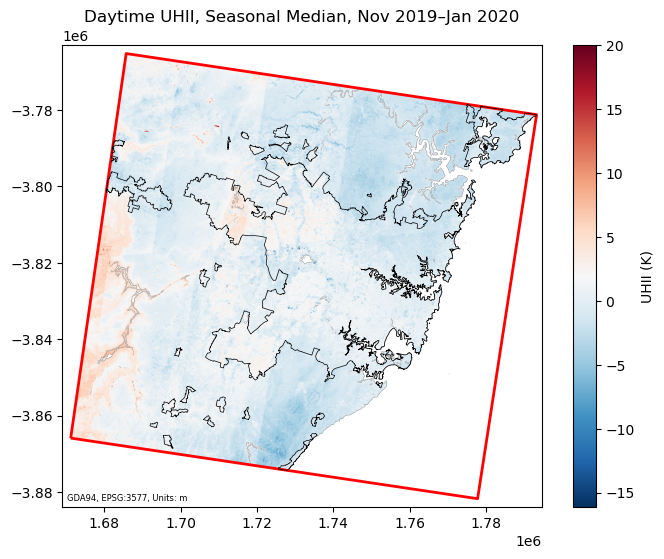

Min: -16.136932373046875 K
Max: 41.833343505859375 K
Mean: 0.05725355741339914 K
Std: 1.9491976410154905 K


In [19]:
out_path = Path('out/NIGHT/UHI_night.tif')
bbox_path = "bbox_sm.gpkg"

with rasterio.open(out_path) as src:
    arr = src.read(1).astype(float)

    # Turn nodata into NaN (if defined)
    if src.nodata is not None:
        arr[arr == src.nodata] = np.nan

    fig, ax = plt.subplots(figsize=(8,6))
    im = show(
        src,
        ax=ax,
        cmap='RdBu_r',
        vmax = 20
    )
    cbar = fig.colorbar(im.get_images()[0], ax=ax)
    cbar.set_label("UHII (K)")
    plt.title("Daytime UHII, Seasonal Median, Nov 2019–Jan 2020")

    bbox_gdf = gpd.read_file(bbox_path).to_crs(src.crs)
    bbox_gdf.boundary.plot(ax=ax, edgecolor="red", linewidth=2)

    urban_gdf = gpd.read_file("urban.gpkg")
    if urban_gdf.crs != src.crs:
        urban_gdf = urban_gdf.to_crs(src.crs)

    urban_clipped = gpd.clip(urban_gdf, bbox_gdf)
    urban_clipped.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5)

    ax.annotate(
        "GDA94, EPSG:3577, Units: m",
        xy=(0.01, 0.01),
        xycoords='axes fraction',
        fontsize=6,
        ha='left',
        va='bottom',
        bbox=dict(facecolor='white', alpha=0.0, edgecolor='none'),
        zorder=1000
    )

    plt.show()

print("Min:", np.nanmin(arr), "K")
print("Max:", np.nanmax(arr), "K")
print("Mean:", np.nanmean(arr), "K")
print("Std:", np.nanstd(arr), "K")

# Hotspots / Coldspots

In [10]:
factor = 3
UHI_coarse_d = UHI_day.coarsen(y=factor, x = factor, boundary="trim").mean(skipna=True)

In [11]:
from esda.getisord import G_Local
from libpysal.weights import lat2W

arr = UHI_coarse_d.values
mask = np.isfinite(arr)

W = lat2W(arr.shape[0], arr.shape[1], rook=True)
W.transform = "r"

z = arr.flatten()
z_filled = np.where(np.isfinite(z), z, np.nanmean(z))

g = G_Local(z_filled, W, permutations=0)

gi_z = g.Zs.reshape(arr.shape)

UHI_gi_d = xr.DataArray(
    gi_z,
    coords=UHI_coarse_d.coords,
    dims=UHI_coarse_d.dims,
    name="UHI_GiZ",
)

In [12]:
urban_day_gi = UHI_gi_d.where(urban_mask)
rur_day_gi = UHI_gi_d.where(~urban_mask)

urban_vals = urban_day_gi.values[np.isfinite(urban_day_gi.values)]
rur_vals   = rur_day_gi.values[np.isfinite(rur_day_gi.values)]

urban_vals_capped = nop

NameError: name 'nop' is not defined

In [ ]:
UHI_gi_d.rio.to_raster('out/DAY/UHI_GiZ_d_100m.tif')

In [ ]:
with rasterio.open('out/DAY/UHI_GiZ_d_100m.tif') as src:
    fig, ax = plt.subplots(figsize=(8, 6))
    im = show(
        src,
        ax=ax,
        cmap="RdBu_r",
        vmin=-3,
        vmax=3
    )

    cbar = fig.colorbar(im.get_images()[0], ax=ax)
    cbar.set_label("Gi* Z-score")
    plt.title("Daytime UHII Hotspots (Getis-Ord Gi*)")

    bbox_gdf = gpd.read_file("bbox_sm.gpkg")
    if bbox_gdf.crs != src.crs:
        bbox_gdf = bbox_gdf.to_crs(src.crs)

    bbox_gdf.boundary.plot(
        ax=ax,
        edgecolor="red",
        linewidth=2
    )

    urban_gdf = gpd.read_file("urban.gpkg")
    if urban_gdf.crs != src.crs:
        urban_gdf = urban_gdf.to_crs(src.crs)

    urban_clipped = gpd.clip(urban_gdf, bbox_gdf)

    urban_clipped.boundary.plot(
        ax=ax,
        edgecolor="black",
        linewidth=1
    )

    ax.annotate(
        "GDA94, EPSG:3577, Units: m",
        xy=(0.01, 0.01),
        xycoords='axes fraction',
        fontsize=6,
        ha='left',
        va='bottom',
        bbox=dict(facecolor='white', alpha=0.0, edgecolor='none'),
        zorder=1000
    )

    plt.show()

## Mann Whitney U - Day

In [ ]:
urban_day_gi = UHI_gi_d.where(urban_mask).values.flatten()
rural_day_gi = UHI_gi_d.where(rural_mask).values.flatten()

urban_day_gi = urban_day_gi[np.isfinite(urban_day_gi)]
rural_day_gi = rural_day_gi[np.isfinite(rural_day_gi)]

stat, p = mannwhitneyu(urban_day_gi, rural_day_gi, alternative='two-sided')
print(f"Mann-Whitney U: {stat}, p: {p}")

In [ ]:
def cliffs_delta(a, b):
    a = np.array(a)
    b = np.array(b)
    a = a[np.random.choice(len(a), 50000, replace=False)]
    b = b[np.random.choice(len(b), 50000, replace=False)]
    
    greater = np.sum(a[:, None] > b)
    smaller = np.sum(a[:, None] < b)
    delta = (greater - smaller) / (len(a) * len(b))
    return delta

delta = cliffs_delta(urban_day_gi, rural_day_gi)
print("Cliff’s delta:", delta)

In [ ]:
factor = 3
UHI_coarse_n = UHI_night.coarsen(y=factor, x = factor, boundary="trim").mean(skipna=True)

In [ ]:
from esda.getisord import G_Local
from libpysal.weights import lat2W

arr = UHI_coarse_n.values
mask = np.isfinite(arr)

W = lat2W(arr.shape[0], arr.shape[1], rook=True)
W.transform = "r"

z = arr.flatten()
z_filled = np.where(np.isfinite(z), z, np.nanmean(z))

g = G_Local(z_filled, W, permutations=0)

gi_z = g.Zs.reshape(arr.shape)

UHI_gi_n = xr.DataArray(
    gi_z,
    coords=UHI_coarse_n.coords,
    dims=UHI_coarse_n.dims,
    name="UHI_GiZ",
)

In [ ]:
urban_day_gi = UHI_gi_n.where(urban_mask)
rur_day_gi = UHI_gi_n.where(~urban_mask)

urban_vals = urban_day_gi.values[np.isfinite(urban_day_gi.values)]
rur_vals   = rur_day_gi.values[np.isfinite(rur_day_gi.values)]

In [ ]:
UHI_gi_n.rio.to_raster('out/NIGHT/UHI_GiZ_n_100m.tif')

In [ ]:
with rasterio.open('out/NIGHT/UHI_GiZ_n_100m.tif') as src:
    fig, ax = plt.subplots(figsize=(8, 6))
    im = show(
        src,
        ax=ax,
        cmap="RdBu_r",
        vmin=-3,
        vmax=3
    )

    cbar = fig.colorbar(im.get_images()[0], ax=ax)
    cbar.set_label("Gi* Z-score")
    plt.title("Nighttime UHII Hotspots (Getis-Ord Gi*)")

    bbox_gdf = gpd.read_file("bbox_sm.gpkg")
    if bbox_gdf.crs != src.crs:
        bbox_gdf = bbox_gdf.to_crs(src.crs)

    bbox_gdf.boundary.plot(
        ax=ax,
        edgecolor="red",
        linewidth=2
    )

    urban_gdf = gpd.read_file("urban.gpkg")
    if urban_gdf.crs != src.crs:
        urban_gdf = urban_gdf.to_crs(src.crs)

    urban_clipped = gpd.clip(urban_gdf, bbox_gdf)

    urban_clipped.boundary.plot(
        ax=ax,
        edgecolor="black",
        linewidth=1
    )

    ax.annotate(
        "GDA94, EPSG:3577, Units: m",
        xy=(0.01, 0.01),
        xycoords='axes fraction',
        fontsize=6,
        ha='left',
        va='bottom',
        bbox=dict(facecolor='white', alpha=0.0, edgecolor='none'),
        zorder=1000
    )

    plt.show()